In [23]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
import scipy.stats as stats
from scipy.stats import shapiro, levene, mannwhitneyu
from scipy.stats import ttest_ind, norm, chi2_contingency

# Configuración
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
pd.set_option('display.float_format', '{:.2f}'.format) # para poder visualizar los floats sólo con 2 decimales


# Gestión de los warnings
import warnings
warnings.filterwarnings("ignore")

### Ejericicios de A/B Testing

**Ejercicio 1**

Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").

Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

Pasos que debemos seguir:

- Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

- Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):

    - Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

    - Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

- Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

    - Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.

    - Para el grupo "psa", realiza el mismo cálculo.

- Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

Análisis de resultados:

- Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.

- Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [2]:
df = pd.read_csv('files/marketing_AB.csv', index_col=0)

In [3]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [4]:
df['converted'] = df['converted'].map({False : 0 , True : 1})

In [5]:
def exploracion_dataframe(dataframe, columna_control):
    """
    Realiza un análisis exploratorio básico de un DataFrame, mostrando información sobre duplicados,
    valores nulos, tipos de datos, valores únicos para columnas categóricas y estadísticas descriptivas
    para columnas categóricas y numéricas, agrupadas por la columna de control.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que se va a explorar.
    - columna_control (str): El nombre de la columna que se utilizará como control para dividir el DataFrame.

    Returns: 
    No devuelve nada directamente, pero imprime en la consola la información exploratoria.
    """
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [6]:
exploracion_dataframe(df,"test group")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
user id,int64
test group,object
converted,int64
total ads,int64
most ads day,object
most ads hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TEST GROUP tiene las siguientes valore únicos:


,test group
ad,564577
psa,23524


La columna MOST ADS DAY tiene las siguientes valore únicos:


,most ads day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el AD son: 


,count,unique,top,freq
test group,564577,1,ad,564577
most ads day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el AD son: 


,count,mean,std,min,25%,50%,75%,max
user id,564577.00,1327314.30,188918.06,1000000.00,1163686.00,1327362.00,1490914.00,1654483.00
converted,564577.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00
total ads,564577.00,24.82,43.75,1.00,4.00,13.00,27.00,2065.00
most ads hour,564577.00,14.48,4.84,0.00,11.00,14.00,18.00,23.00



 ..................... 

Los principales estadísticos de las columnas categóricas para el PSA son: 


,count,unique,top,freq
test group,23524,1,psa,23524
most ads day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el PSA son: 


,count,mean,std,min,25%,50%,75%,max
user id,23524.00,911761.50,6790.94,900000.00,905880.75,911761.50,917642.25,923523.00
converted,23524.00,0.02,0.13,0.00,0.00,0.00,0.00,1.00
total ads,23524.00,24.76,42.86,1.00,4.00,12.00,26.00,907.00
most ads hour,23524.00,14.30,4.66,0.00,11.00,14.00,18.00,23.00


In [7]:
# Hacer tabla de contingencia para poder revisar la tasa de conversión con el chi-cuadrado:

tabla_contingencia = pd.crosstab(df['test group'], df['converted'])
tabla_contingencia

converted,0,1
test group,,
ad,550154,14423
psa,23104,420


- Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

- Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".


p_value < 0.05 rechazamos H0, existe una diferencia significativa

p_value > 0.05 no podemos rechazar H0, no existe diferencia significativa

In [8]:
chi2, p_value,_,_= chi2_contingency(tabla_contingencia)
print('{:.2f}'.format(p_value))

0.00


In [9]:
tabla_contingencia['% conversion'] = round(tabla_contingencia[1] / tabla_contingencia[0] *100 , 2)

In [13]:
tabla_contingencia.index

Index(['ad', 'psa'], dtype='object', name='test group')

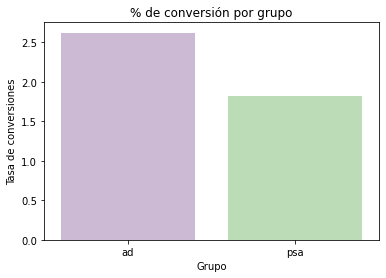

In [16]:
sns.barplot(x= tabla_contingencia.index, 
            y = '% conversion', 
            data = tabla_contingencia,
            palette = 'PRGn')

plt.title("% de conversión por grupo")
plt.ylabel("Tasa de conversiones")
plt.xlabel("Grupo");

**Conclusiones**: Observamos que hay una diferencia significativa entre ambas hipótesis y, por ende, rechazamos H0. Sin embargo, al revisar la tasa de conversión de los dos grupos y aunque vemos que en efecto el nuevo diseño de anuncio sí es más efectivo, no vemos que esta efectividad sea exageradamente superior. Por tanto, antes de implementar los cambios preferiríamos evaluar el coste que tendría su implementación para ver si supondría una mejora significativa o no.

**Ejercicio 2**

En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

Pasos que debemos seguir:

- Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

- Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

- Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

Análisis de resultados:

- Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.

- Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

Partiremos de la siguientes hipótesis:

- Hipótesis nula (H0): No hay diferencia significativa en la cantidad de anuncios vistos en los grupos de prueba "ad" y "psa".

- Hipótesis alternativa (H1): Existe una diferencia significativa en la cantidad de anuncios vistos en los grupos de prueba "ad" y "psa".

In [22]:
# Revisamos la media y la mediana de total ads, según el grupo:

df.groupby('test group')['total ads'].agg(['mean' , 'median'])

,mean,median
test group,,
ad,24.82,13.00
psa,24.76,12.00


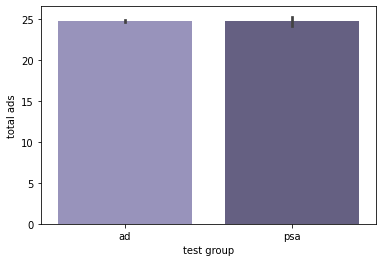

In [27]:
sns.barplot(data = df, 
            y = "total ads", 
            x = "test group",
            palette = "Purples_d");

**Revisión de normalidad**

H0: Datos normales

H1: Datos no normales

In [30]:
# Revisamos si los datos de total ads cumplen con el criterio de normalidad
_,p_value = shapiro(df['total ads'])
print(f"p-Value: {p_value}")

p-Value: 0.0


Como el p_value es < 0.05 rechazamos la H0 (datos normales).

Los datos no son normales, por lo que hacer un t de Student quedaría descartado

**Revisión de homogeneidad**

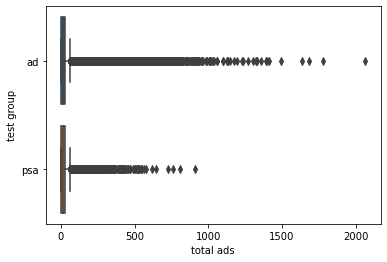

In [31]:
sns.boxplot(x = "total ads", data = df, y = "test group");

H0: Datos homogeneos

H1: Datos no homogeneos

In [33]:
control = df[df['test group'] == 'psa']
test = df[df['test group'] == 'ad']

_,p_value = levene(control['total ads'],test['total ads'])
p_value

0.020628382759511198

Como el p_value es < 0.05 rechazamos la H0 (datos homogeneos).

Los datos no son homogeneos

**Revisión de independencia**

H0: Datos independientes

H1: Datos dependientes

In [37]:
# Realizar la prueba de chi-cuadrado para evaluar la independencia de dos variables categóricas
contingency_table = pd.crosstab(df['test group'], df['total ads'])
chi2, p_chi2, _, _ = chi2_contingency(contingency_table)
print(f"Prueba de Chi-cuadrado - p-valor: '{p_value:.2f}'")

Prueba de Chi-cuadrado - p-valor: '0.02'


Como el p_value es < 0.05 rechazamos la H0 (datos independientes).

Los datos son dependientes, no homogeneos y no cumplen con la normalidad. Por tanto, nos decantaremos por utilizar una prueba no paramétrica, el **Test de Mann Whitney**

**Prueba no paramétrica para contrastar nuestras hipótesis - Test de Mann Whitney**

In [46]:
# aplicamos el estadístico
u_statistic, p_value = stats.mannwhitneyu(control['total ads'], test['total ads'])

if p_value < 0.05:
    print(f"{p_value:.2f}")
    print(f"Para la métrica total ads, las medianas son diferentes.")
    print(f"Se rechaza la H0")
    
else:
    print(f"{p_value:.2f}")
    print(f"Para la métrica total ads, las medianas son iguales.")
    print(f"No se puede rechazar H0")

0.00
Para la métrica total ads, las medianas son diferentes.
Se rechaza la H0


**Conclusiones**: Observamos que hay una diferencia significativa entre ambas hipótesis y, por ende, rechazamos H0 en favor de H1. 

El grupo de prueba (ad) logra ver más anuncios que el grupo de control (psa).